In [2]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import scipy.io
import xml.etree.ElementTree as ET
import re
import random
from unidecode import unidecode
from PIL import Image, ImageOps
from tqdm.auto import tqdm
import uuid
import shutil

np.random.seed(42)
tf.random.set_seed(42)

# enable Dynamy Memory Allocation
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

GENERATE_EMNIST_HANDWRITTEN_SENTENCES = False
GENERATE_VIRTUAL_DATASET = False
CUDA_VISIBLE_DEVICES=0

#### Load data
##### We need at least 100 000 images in total, so we might cut or add data to some datasets.


##### Load IAM-Handwritten-Database words, sentences and

In [6]:
iam_root_path = './data/IAM-Handwritten-Database/'
iam_dataset = [] # format : {"image_path": ..., "laabel": ...}

# Function taht : 
# opens iam words data descrpition file
# If line is not a comment and image is formatted correctly, add the image data
# File names in are formated like this :
# part1-part2-part3
# Files a stored like this on hard drive :
# part1/part1-part2/part1-part2-part3.png
# filter only well formetted files which size are > 0 bytes
# remove every spaces between punctuation, every newline, trailing spaces and vertical bars from label
def get_iam_handwritten_db_data(data_type):
    dataset = []
    with open(os.path.join(iam_root_path, data_type + ".txt"), 'r') as iam_data_file:
        segmentation_result_idx =  1 if data_type == 'words' or data_type == 'line' else 2
        lines = [line for line in iam_data_file]
        for line in lines:
            splitted_line = line.split(' ')
            if line[0] != '#' and splitted_line[segmentation_result_idx] != 'err': # if line is not a comment and file is formatted correctly
                splitted_image_name = splitted_line[0].split('-')
                img_path = os.path.join(
                    iam_root_path,
                    data_type,
                    splitted_image_name[0],
                    splitted_image_name[0] + '-' + splitted_image_name[1],
                    splitted_line[0] + ".png"
                )
                if os.path.exists(img_path) and os.path.getsize(img_path) > 0: #we only keep files that exists and are > 0 bytes
                    dataset.append({
                        "image_path": img_path,
                        "label": re.sub (r'\s([?.!,\'-;/](?:\s|$))', r'\1' , splitted_line[-1].split('\n')[0].replace('|', ' ').strip()) 
                    })
    return dataset

iam_dataset = iam_dataset + get_iam_handwritten_db_data('sentences')


# iam_dataset = iam_dataset + get_iam_handwritten_db_data('lines')
# iam_dataset = iam_dataset + get_iam_handwritten_db_data('words')


##### Load ICDAR 2003 Robust Reading Competitions - Robust Word Recognition dataset

In [7]:
icdar_2023_words_root = "./data/ICDAR 2003 Robust Reading Competitions/Robust Word Recognition/"
icdar_2023_words_dataset = []

# Function that read xml file to create formatted dataset
def get_icdar_2003_words_data(xml_filepath):
    dataset = []
    dirname = os.path.dirname(xml_filepath)
    image_list = ET.parse(xml_filepath).getroot()

    for image in image_list:
        img_path = os.path.join(dirname, image.attrib["file"])
        if os.path.exists(img_path) and os.path.getsize(img_path): #we only keep files that exists and are > 0 bytes
            dataset.append({
                "image_path": img_path,
                "label": image.attrib['tag']
            })
    return dataset
    

icdar_2023_words_dataset = icdar_2023_words_dataset + get_icdar_2003_words_data(os.path.join(icdar_2023_words_root, "Sample Set", "word.xml"))
icdar_2023_words_dataset = icdar_2023_words_dataset + get_icdar_2003_words_data(os.path.join(icdar_2023_words_root, "TrialTest Set", "word.xml"))
icdar_2023_words_dataset = icdar_2023_words_dataset + get_icdar_2003_words_data(os.path.join(icdar_2023_words_root, "TrialTrain Set", "word.xml"))

##### Generate EMNIST and load dataset

In [11]:
from emnist import extract_samples

if GENERATE_EMNIST_HANDWRITTEN_SENTENCES == True :

    EMNIST_HANDWRITTEN_SENTENCES_ROOT = "./data/EMNIST-Handwritten-Characters-French/"

    EMNIST_LABEL_TO_CHAR = [
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J','K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T','U', 'V', 'W', 'X', 'Y', 'Z',
        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j','k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't','u', 'v', 'w', 'x', 'y', 'z',
    ]
    CHAR_SIZE = 28

    # Functions that returns emnist letters and digits in the following format : {'a': [all 'a' images], 'b': all 'b' images, ...}
    def get_emnist_sorted_by_label():
        dataset = {}
        emnist_train_images, emnist_train_labels = extract_samples('byclass', 'train')
        emnist_test_images, emnist_test_labels = extract_samples('byclass', 'test')
        images, labels = np.concatenate((emnist_train_images, emnist_test_images)), np.concatenate((emnist_train_labels, emnist_test_labels))
        labels_set = sorted(list(set(label for label in labels)))
        
        for unique_label_idx in labels_set:        
            matching_indices = [i for i in range(len(labels)) if labels[i] == unique_label_idx]
            dataset[EMNIST_LABEL_TO_CHAR[unique_label_idx]] = list(
                map(
                    lambda index: images[index] ,
                    matching_indices
                )
            )
        return dataset

    # Function that adds up EMNIST images array to create given word
    def create_handwritten_string_matrix(string, characters_bank):
        splitted_string = string.split('\n')
        string_matrix = np.zeros((
            len(splitted_string) * CHAR_SIZE, # Height
            len(max(splitted_string, key=len)) * CHAR_SIZE # Width
        ))
        current_y = 0
        for string_part in splitted_string:
            for i in range(len(string_part)):
                char = string_part[i]
                letter_matrix = random.choice(characters_bank[char]) if char != ' ' else np.zeros((28, 28))
                string_matrix[current_y:current_y+CHAR_SIZE, CHAR_SIZE*i:CHAR_SIZE*(i+1)] = letter_matrix
            current_y = current_y + CHAR_SIZE
        return string_matrix

    # Function that loop over all dictionnary words, create and save handwritten words
    def save_handwritten_sentences_on_disk(sentences, characters_bank, directory, iterations=1):
        # Create directory if does not exists
        if os.path.exists(directory) == False: os.makedirs(directory)
        # Open and create data file if does not exists
        data_file = open(os.path.join(directory, "data.txt"), "a+")
        
        for _ in range(iterations):
            for sentence in tqdm(sentences):
                image = Image.fromarray(create_handwritten_string_matrix(sentence, characters_bank)).convert('L')
                image = ImageOps.invert(image)
                file_name = str(uuid.uuid1()) + ".png"
                image.save(os.path.join(directory, file_name))
                sentence = sentence.replace('\n', '|')  # We add the sentence but replace all '\n' by '|'
                data_file.write(f"{file_name} {sentence}\n") # We write the file name seperated by a space with label
        data_file.close()

    def get_random_sentences(dicitonary, words_range=(4, 15), size=20_000):
        sentences = []
        for _ in range(size):
            sentence = ' '.join(random.choices(dicitonary, k=random.randint(words_range[0], words_range[1])))
            for i in  range(len(sentence)):
                if sentence[i] == ' ' and random.randint(0, 100) <= 15: #15% chancve of a new line
                    sentence = sentence[:i] + '\n' + sentence[i+1:]
            sentences.append(sentence)
        return sentences    


    # Create formatted EMNIST label dataset
    emnist_sorted_by_label = get_emnist_sorted_by_label()
    #Open french dictionnary file
    french_dictionnary = open('./data/dela-fr-public.txt').readlines()
    # Transform words so they have no accents
    french_dictionnary = list(map(lambda line:  unidecode(line.split(',')[0]), french_dictionnary))
    # Filter to remove words with special characters
    french_dictionnary = list(filter(lambda word: bool(re.match('^[a-zA-Z0-9]*$', word)), french_dictionnary))

    # Remove old generated data if exists
    if os.path.exists(EMNIST_HANDWRITTEN_SENTENCES_ROOT):
        shutil.rmtree(EMNIST_HANDWRITTEN_SENTENCES_ROOT)
    
    # Call function that will create and save handwritten words
    save_handwritten_sentences_on_disk(
        get_random_sentences(french_dictionnary),
        emnist_sorted_by_label,
        EMNIST_HANDWRITTEN_SENTENCES_ROOT
    )

 # Function that Loads handwritten words
def get_EMNIST_handwritten_data(directorty):
    dataset = []
    data_file = open(os.path.join(directorty, "data.txt")).readlines()

    for line in data_file:
        splitted_line = line.split(' ', 1) #splitted_line[0] = image file_name, splitted_line[1] = label
        img_path = os.path.join(directorty, splitted_line[0])
        if os.path.exists(img_path) and os.path.getsize(img_path) > 0: # If file exist and size > 0
            dataset.append({
                "image_path": img_path,
                "label": splitted_line[1].split('\n')[0].strip()
            })    
    return dataset

emnist_dataset = get_EMNIST_handwritten_data("./data/EMNIST-Handwritten-Characters-French/")


##### Load handwritten generated text dataset

In [8]:
HANDWRITTEN_GENERATED_DATESET_DIRECTORY = './data/handwritten-generated-text'

# Functions taht loads the handwritten generated dataset
def get_handwritten_generated_dataset(directory):
    dataset = []
    data_file = open(os.path.join(directory, "data.txt")).readlines()

    for line in data_file:
        splitted_line = line.split(' ', 1) #splitted_line[0] = image file_name, splitted_line[1] = label
        img_path = os.path.join(directory, splitted_line[0] + ".png")
        if os.path.exists(img_path) and os.path.getsize(img_path) > 0: # If file exist and size > 0
            dataset.append({
                "image_path": img_path,
                "label": splitted_line[1].split('\n')[0].strip()
            })
    return dataset

handwritten_generated_dataset = get_handwritten_generated_dataset(HANDWRITTEN_GENERATED_DATESET_DIRECTORY)

#### Create virtual data to obtain a total of 100_000 images and load virtual datasets

In [9]:
VIRTUAL_DATASET_ROOT = './data/Virtual-Dataset'

if GENERATE_VIRTUAL_DATASET == True:

    def generate_new_image(image_paths):
            images = [Image.open(image_path) for image_path in image_paths]
            max_width = max(list(map(lambda image: image.width, images)))
            images_height = list(map(lambda image: image.height, images))
            bg_img = Image.new('RGB', (max_width, sum(images_height)), (255, 255, 255))
            for i in range(len(image_paths)):
                new_image = images[i]
                if i == 0:
                    bg_img.paste(new_image, (0, 0))
                else:
                    bg_img.paste(new_image, (0, sum(images_height[:i])))
            return bg_img

    # Function that generate the virtual dataset
    def generate_virtual_dataset(length, datasets_array, directory_name):

        # Remove old generated data if exists
        # if os.path.exists(os.path.join(VIRTUAL_DATASET_ROOT, directory_name)):
        #     shutil.rmtree(os.path.join(VIRTUAL_DATASET_ROOT, directory_name))
        # # Create directory if does not exists
        # if os.path.exists(os.path.join(VIRTUAL_DATASET_ROOT, directory_name)) == False: os.makedirs(os.path.join(VIRTUAL_DATASET_ROOT, directory_name))
        
        data_file = open(os.path.join(VIRTUAL_DATASET_ROOT, directory_name, "data.txt"), "a+")
       
        for i in tqdm(range(length)):
            image_nb = random.randint(7, 20)
            new_images_data = []
            for _ in range(image_nb):
                new_images_data.append(random.choice( datasets_array[random.randint(0, len(datasets_array) - 1)] ))
            generate_new_image(list(map(lambda image_data: image_data["image_path"], new_images_data))).save(os.path.join(VIRTUAL_DATASET_ROOT, directory_name, f"{i}.png"))
            labels = '\n'.join( list( map( lambda image_data: image_data['label'], new_images_data ) ) ).replace('\n', '|').split('\n')[0].strip()
            data_file.write(f"{i} {labels}\n")
        data_file.close()

    total_len = 100_000 - (len(iam_dataset) + len(icdar_2023_words_dataset) + len(emnist_dataset) + len(handwritten_generated_dataset))
    only_image_len = int(total_len / 2)
    mixed_len = total_len - only_image_len

    generate_virtual_dataset(
        only_image_len,
        [
            icdar_2023_words_dataset,            
        ],
        "only-images"
    )
    generate_virtual_dataset(
        mixed_len,
        [
            icdar_2023_words_dataset,
            icdar_2023_words_dataset,
            icdar_2023_words_dataset,
            icdar_2023_words_dataset,
            iam_dataset,
            emnist_dataset,
            handwritten_generated_dataset
        ],
        "mixed"
    )
# Function that load virtual dataset
def get_virtual_dataset(directory):
    dataset = []
    data_file = open(os.path.join(directory, "data.txt")).readlines()
    for line in data_file:
        splitted_line = line.split(' ', 1) #splitted_line[0] = image file_name, splitted_line[1] = label
        img_path = os.path.join(directory, splitted_line[0] + ".png")
        if os.path.exists(img_path) and os.path.getsize(img_path) > 0: # If file exist and size > 0
            dataset.append({
                "image_path": img_path,
                "label": splitted_line[1].split('\n')[0].strip()
            })
    return dataset

only_images_virtual_dataset = get_virtual_dataset(os.path.join(VIRTUAL_DATASET_ROOT, 'only-images'))
mixed_virtual_dataset = get_virtual_dataset(os.path.join(VIRTUAL_DATASET_ROOT, 'mixed'))

##### Create Model

In [19]:
dataset = iam_dataset + icdar_2023_words_dataset + emnist_dataset + handwritten_generated_dataset + only_images_virtual_dataset + mixed_virtual_dataset
dataset = dataset[:80_000]
print(len(dataset))
# For computer vision deep learning, there is a consensus saying that a dataset of 1000 labeled images for each classes is needed
image_paths = list(map(lambda data: data["image_path"], dataset))
labels = list(map(lambda data: data["label"].replace('|',  '\n'), dataset))
np.random.shuffle(dataset)

train_ds = dataset[:int(0.98*len(dataset))] #98% of the whole dataset is train dataset
validation_ds = dataset[int(0.98*len(dataset)):int(0.99*len(dataset))] #1% is  validation dataset
test_ds = dataset[int(0.99*len(dataset)):] #1% is test dataset


#################

AUTOTUNE = tf.data.AUTOTUNE # Let tf decide the best tunning algos

characters = sorted(list(set(char for label in labels for char in label)))
print(len(characters))
max_len = len(max(labels, key=len))
print(max_len)

# Mapping characters to integer -> returns a function
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters -> returns a function
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

batch_size = 64
padding_token = 99
image_height = max_len if max_len >= 32 else 32
image_width = image_height * 4

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path) # Open file with tf
    image = tf.image.decode_png(image, channels=1) # transform to matrix of gray scale value
    image = distortion_free_resize(image, img_size) # Distort image
    image = tf.cast(image, tf.float32) / 255.0 # Transform image to data into matrix of gray scale float32 values in range [0, 1]
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    # return tf.data.Dataset.from_tensor_slices(
    #     (image_paths, labels)
    # ).map(
    #     process_images_labels, num_parallel_calls=AUTOTUNE
    # ).batch(batch_size).cache(filename='./cache').shuffle(len(labels)).prefetch(AUTOTUNE)
    return tf.data.Dataset.from_tensor_slices(
        (image_paths, labels)
    ).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    ).batch(batch_size) #.prefetch(AUTOTUNE)

train_ds = prepare_dataset(list(map(lambda data: data["image_path"], train_ds)), list(map(lambda data: data["label"], train_ds)))
validation_ds = prepare_dataset(list(map(lambda data: data["image_path"], validation_ds)), list(map(lambda data: data["label"], validation_ds)))
test_ds = prepare_dataset(list(map(lambda data: data["image_path"], test_ds)), list(map(lambda data: data["label"], test_ds)))

#################

#### !!!! CHECK SI EN RESIZANT LES IMAGES EMNIST AVE TF ON A UN TRUC ENCORE LISIBLE

## shuffle
## split in 98:1:1


80000
96
216


In [14]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        for y in y_true:
            print(y)
            break

        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss", )(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    # opt = keras.optimizers.Adam()
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
#model.summary()

Tensor("ctc_loss/while/TensorArrayV2Read/TensorListGetItem:0", shape=(None,), dtype=float32)


In [9]:
######## EVALUATION METRICS
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [10]:
epochs = 10  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

edit_distance_callback = EditDistanceCallback(prediction_model)

early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)


# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/10
1/1 [==============================] - 0s 62ms/step
Mean edit distance for epoch 1: 215.9892
1225/1225 [==============================] - 324s 258ms/step - loss: inf - val_loss: 235.4393
Epoch 2/10
1/1 [==============================] - 0s 53ms/step
Mean edit distance for epoch 2: 215.0577
1225/1225 [==============================] - 319s 260ms/step - loss: inf - val_loss: 225.9301
Epoch 3/10
1/1 [==============================] - 0s 49ms/step
Mean edit distance for epoch 3: 214.4303
1225/1225 [==============================] - 306s 250ms/step - loss: inf - val_loss: 218.1182
Epoch 4/10
1/1 [==============================] - 0s 57ms/step
Mean edit distance for epoch 4: 208.5613
1225/1225 [==============================] - 308s 251ms/step - loss: inf - val_loss: 198.2930
Epoch 5/10
1/1 [==============================] - 0s 59ms/step
Mean edit distance for epoch 5: 214.6154
1225/1225 [==============================] - 311s 254ms/step - loss: inf - val_loss: 259.5031
Epoch 6/10

In [11]:
### SAVE MODEL
MODEL_SAVE_DIRECTORY = './CNN-OCR-MODEL-SAVE-V3/'

model.save(MODEL_SAVE_DIRECTORY)

INFO:tensorflow:Assets written to: ./CNN-OCR-MODEL-SAVE-V3/assets


INFO:tensorflow:Assets written to: ./CNN-OCR-MODEL-SAVE-V3/assets


2/2 [==============================] - 0s 73ms/step


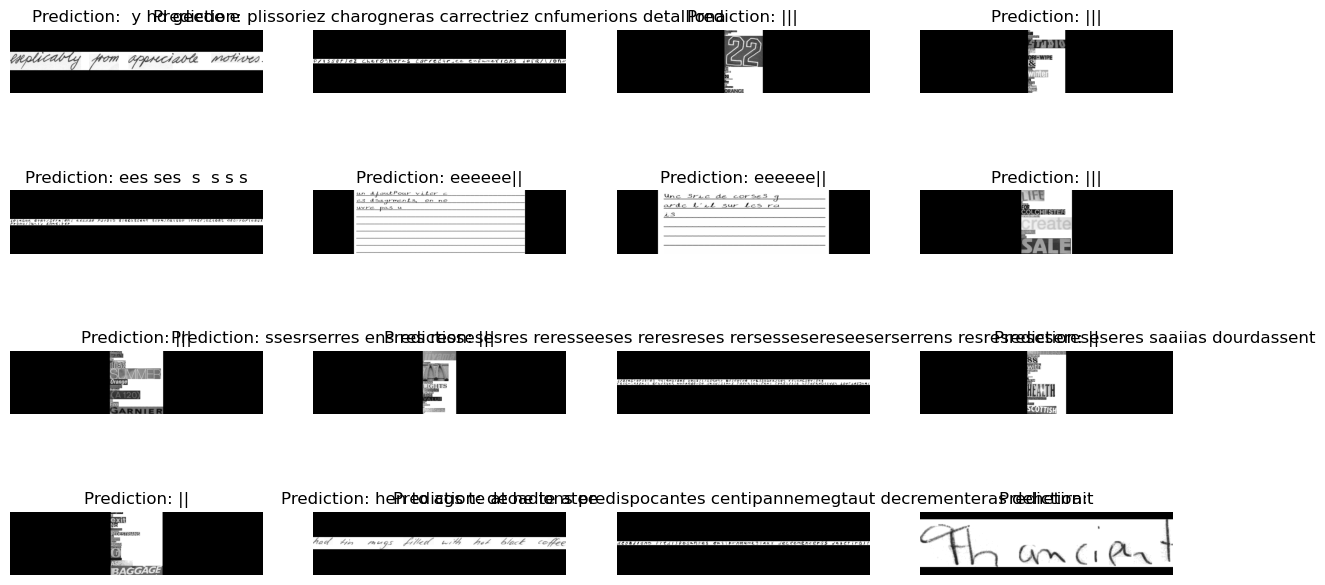

In [12]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()